### **Import Data**

In [50]:
#import packages
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [141]:
#import JP Morgan Stock Price
jpm = pd.read_csv('C:/Users/Heidi/Desktop/MMAI Course/894 Deep Learning/Project/0.0-sh-data-JPM.csv')

### **Create Feature Table and Normalize Data**

In addition to the original price/volume/dividend/split feature, create some momentum features to consider the impact of previous days' prices on stock prediction, given the autocorrelation nature of time series. Example

- **Lag prices**: stock price in previous days
- **Moving average**: the average stock price in a defined window period 
- **Volatility**: standard deviation of the changes stock price
- **Target** is the predicted stock price, which is the t+1 price

In [142]:
#Create Lag features to consider the stock price in previous days
jpm['lag_t-1']=jpm['Adj_Close'].shift(1)
jpm['lag_t-2']=jpm['Adj_Close'].shift(2)
jpm['lag_t-3']=jpm['Adj_Close'].shift(3)
jpm['lag_t-4']=jpm['Adj_Close'].shift(4)
jpm['lag_t-5']=jpm['Adj_Close'].shift(5)

#Create Stock Volatility data
jpm['volatility']=jpm['Adj_Close'].rolling(21).std()

#Create Moving Average features
jpm['SMA'] = jpm['Adj_Close'].rolling(50).mean() #simple Moving Average for a window of 10 days
jpm['EMA'] = jpm['Adj_Close'].ewm(span = 25, min_periods = 12).mean() #Exponential Moving Average for a window of 12 days

#Create Return feature
jpm['return']=jpm['Adj_Close'].diff(1)/jpm['Adj_Close'].shift(1)
jpm['cumsum']=jpm['return'].cumsum()

#Create stock price predicting the target (t+1) price
jpm['target']=jpm['Adj_Close'].shift(-1)


jpm.head(5)

,Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,...,lag_t-2,lag_t-3,lag_t-4,lag_t-5,volatility,SMA,EMA,return,cumsum,target
0,2008-12-09,35.67,35.70,33.66,33.96,65827700.0,0.0,1.0,28.447812,28.471738,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.733128
1,2008-12-10,34.40,34.96,33.08,33.52,47919600.0,0.0,1.0,27.434952,27.881568,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.012956,-0.012956,23.877979
2,2008-12-11,32.60,32.76,29.74,29.94,70746400.0,0.0,1.0,25.999402,26.127007,...,27.084040,NaN,NaN,NaN,NaN,NaN,NaN,-0.106802,-0.119758,24.675506
3,2008-12-12,28.44,31.22,28.01,30.94,59939000.0,0.0,1.0,22.681687,24.898814,...,26.733128,27.084040,NaN,NaN,NaN,NaN,NaN,0.033400,-0.086358,22.833217
4,2008-12-15,29.34,29.78,28.17,28.63,51629100.0,0.0,1.0,23.399462,23.750374,...,23.877979,26.733128,27.08404,NaN,NaN,NaN,NaN,-0.074661,-0.161019,25.800020


In [143]:
#Create variable X contains Features
X = np.array(jpm.iloc[50:-1,1:-2])
print('Variable X Shape', X.shape)

#Create variable Y represent target
Y=jpm['target'].iloc[50:-1].values.reshape(-1,1)
print('Variable Y Shape', Y.shape)

Variable X Shape (2466, 21)
Variable Y Shape (2466, 1)


In [144]:
#Data Normalization
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#print(scaler.fit(x_array))
MinMaxScaler(copy=True, feature_range=(0, 1))
X_Nor=scaler.fit_transform(X)
Y_Nor=scaler.fit_transform(Y)

In [145]:
#Split Train & Test dataset
X_train=X_Nor[:1800,:]
y_train=Y_Nor[:1800,:]
X_test=X_Nor[1801:,:]
y_test=Y_Nor[1801:,:]

### **XGBoost Model for Logistic Regression**

**XGBoost** is an implementation of gradient boosted decision trees designed for speed and performance. 
<br/>**Gradient boosting** is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models. 
<br/><br/> 
- The **lowest RMSE** (Root Mean Square Error) under this method is  0.021091299979040603

In [146]:
#Import XGBoosting Packages
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import linear_model, model_selection
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import GridSearchCV

In [147]:
#Parameter Search using Grid Search
dmatrix = xgb.DMatrix(data=X_train, label=y_train)
gbm_param_grid = {
    'nthread':[-1],
    'learning_rate': [0.0001,0.001,0.01,0.1],
    'colsample_bytree': [0.1,0.5,0.9],
    'n_estimators': [15,50,200],
    'subsample':[0.4,0.6,0.8],
    'max_depth':[3,5,8],
    'min_child_weight':[1,5,8],
    'seed':[12,123],
    'objective':['reg:logistic']
    #'reg_alpha':[1e-6], 
    #'reg_lambda':[2e-6]
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor()

# Perform grid search: grid_mse
logreg_mse = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid,
                        scoring='neg_mean_squared_error', cv=5, verbose=1,n_jobs=-1)
logreg_mse.fit(X_train, y_train.ravel())
y_predict=logreg_mse.predict(X_test)
y_fit=logreg_mse.predict(X_train)

# Print the best parameters and lowest log loss
print("Best parameters found: ", logreg_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(logreg_mse.best_score_)))

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 351 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 851 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1551 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2451 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3510 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 4522 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 5673 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 6927 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 8242 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 9601 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 9720 out of 9720 | elapsed: 12.4min finished


Best parameters found:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 200, 'nthread': -1, 'objective': 'reg:logistic', 'seed': 12, 'subsample': 0.8}
Lowest RMSE found:  0.02065684518469964


### Stock Price Fitting

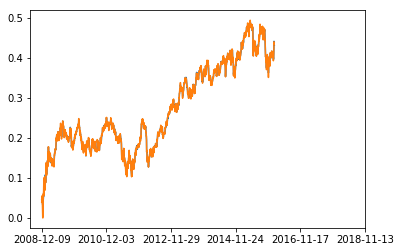

<Figure size 1296x648 with 0 Axes>

In [148]:
#Fit the predicting data with the training data
plt.plot(y_fit)
plt.plot(y_train)
plt.xticks(range(0,jpm.shape[0],500),jpm['Date'].loc[::500])
plt.figure(figsize = (18,9))
plt.show()

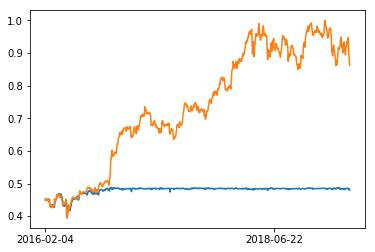

<Figure size 1296x648 with 0 Axes>

In [149]:
#Fit the predicting data with the testing data
plt.plot(y_predict)
plt.plot(y_test)
plt.xticks(range(0,X_test.shape[0],500),jpm['Date'].loc[len(X_train)::600])
plt.figure(figsize = (18,9))
plt.show()

### Autocorrelation Measurement
#### First calculate Xt - Xt-1 = error term, also called white noise, which use the np.diff() function
- **Graph 1 - returns**: process appears to follow random walk and centered about zero 

- **Autocorrelation & Partial Autocorrelation Plot**: indicate no significant serial correlation. But some serial correlation in the ACF, and PACF plots around lags 8, 14, 20, 21, 24 and 30. This means that there should be better models to describe the actual price change process. 

- **QQ and Probability Plots**：QQ plot visually assesses whether sample data comes from a specified distribution. For this model, the shape of QQ and Probability plots indicates that the process is close to normality but with 'heavy tails'.

This code was adapted from the blog http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

In [151]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [152]:
y_predict.shape

(665,)

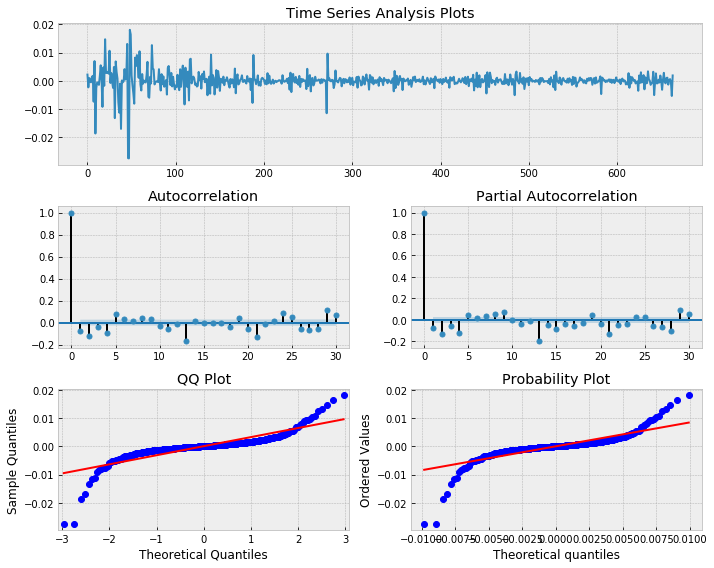

In [153]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

tsplot(np.diff(y_predict),30)

### **GARCH Model**
<br/>Traditional Time Series Analysis methods in Quantatitive Finance include Autoregressive Models and Moving Average Models, Both of them consider the impact of **autocorrelation issue**, also called **serial correlation**. Popular models include but not limited to:
<br/> 
- Autoregressive Moving Average Models - **ARMA(p, q)**
<br/> 
- Autoregressive Integrated Moving Average Models - **ARIMA(p, d, q)**
<br/> 
- Autoregressive Conditionally Heterskedastic Models - **ARCH(p)**
<br/> 
- Generalized Autoregressive Conditionally Heterskedastic Models - **GARCH(p, q)**